In [2]:
import BioSimSpace as bss
import glob
bss.setVerbose(True)
print(bss.__version__)
import lomap
import networkx as nx
import os
import csv

2022.2.1+47.g7ab37c02


# LOMAP on ligands

Lester is working on this. 

In [6]:
# get ligand names
import BioSimSpace as bss
import glob
ligand_path = "../inputs/ligands/lomap/"
ligand_files = glob.glob(ligand_path+"*.sdf")

ligands = []
ligand_names = []
for file in ligand_files:
    ligand_name = file.split("/")[-1].replace(".sdf", "")
    ligand_names.append(ligand_name)
    print(ligand_name)
    ligand = bss.IO.readMolecules(file)[0]
    ligands.append(ligand)

transformations, lomap_scores = bss.Align.generateNetwork(ligands, plot_network=True, names=ligand_names, work_dir="tmp")

for t, s in sorted(zip(transformations, lomap_scores), key = lambda x:x[1]):
    print(f"({ligand_names[t[0]]}, {ligand_names[t[1]]}), {s}")


lig_15
lig_4
lig_12
lig_13
lig_2
lig_10
lig_9
lig_6
lig_7
lig_14
lig_8
lig_1
lig_11
lig_3
lig_5
lig_16


AlignmentError: Unable to create network plot!: TypeError("argument of type 'float' is not iterable")

## Manual lomap

In [278]:
lomap_ligand_path = "../inputs/ligands/lomap/"

lomap_database = lomap.DBMolecules(f"{lomap_ligand_path}", 
                                   output=True,
                                   output_no_graph=True,
                                   output_no_images=True,
                                   threed=True,
                                   max3d=3.0,
                                   time=3,
                                   parallel=10)
strict, loose = lomap_database.build_matrices()
nx_graph = lomap_database.build_graph()
lomap_file = "out_score_with_connection.txt"

if not os.path.isfile(lomap_file):
    raise FileNotFoundError("LOMAP output file doesn't exist!")

In [279]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pydot

from rdkit.Chem import AllChem as allchem
from rdkit.Chem import Draw as draw
from rdkit.Chem import rdmolops as rdmolops
from rdkit.Chem import rdFMCS as rdfmcs
# Set the DPI to make the network look nice.
plt.rcParams["figure.dpi"]= 150

# Make directory for output images.
os.makedirs(lomap_ligand_path+"/images", exist_ok=True)
rdmols = []

for x, name in zip(range(0, len(ligands)), ligand_names):
     file = f"{lomap_ligand_path}/{name}.sdf"
     rdmols.append(rdkit.Chem.SDMolSupplier(file, sanitize=False, removeHs=False)[0])
    
rdmols = [rdkit.Chem.RemoveHs(mol) for mol in rdmols]
template = rdkit.Chem.MolFromSmarts(rdfmcs.FindMCS(rdmols,
                                atomCompare=rdfmcs.AtomCompare.CompareAny,
                                bondCompare=rdfmcs.BondCompare.CompareAny,
                                matchValences=False,
                                ringMatchesRingOnly=True,
                                completeRingsOnly=True,
                                matchChiralTag=False).smartsString)
allchem.Compute2DCoords(template)

for x, mol in enumerate(rdmols):
    mol.UpdatePropertyCache(strict=False)
    allchem.Compute2DCoords(mol)
    allchem.GenerateDepictionMatching2DStructure(mol, template)

    mol = rdkit.Chem.RemoveHs(mol)

    # Remove stereochemistry to simplify depiction in network.
    rdmolops.RemoveStereochemistry(mol)
    draw.MolToFile(mol, f"{lomap_ligand_path}/images/{x:03d}.png")


In [280]:
edges = []
nodes = []
scores = []
edges_excluded = []

with open(lomap_file, "r") as csv_file:
    csv_reader = csv.reader(csv_file)
    for row in csv_reader:
        if row[7].strip() == "Yes":
            mol0 = int(row[2].rsplit(".")[0].rsplit("_")[-1])
            mol1 = int(row[3].rsplit(".")[0].rsplit("_")[-1])
            score = float(row[4])
            edges.append((mol0, mol1))
            nodes.append(mol0)
            nodes.append(mol1)
            scores.append(score)
        elif row[7].strip() == "No":
            mol0 = int(row[2].rsplit(".")[0].rsplit("_")[-1])
            mol1 = int(row[3].rsplit(".")[0].rsplit("_")[-1])
            score = float(row[4])
            if not (mol1, mol0) in edges:
                edges_excluded.append((mol0, mol1, score))


In [366]:
import pandas as pd
nodes = set(nodes)
edge_dict = {}
for count, (node0, node1) in enumerate(edges):
    node0_str = "lig_"+str(node0)
    node1_str = "lig_"+str(node1)
    edge_dict[(node0_str, node1_str)] = round(scores[count], 4)

edges_df = pd.DataFrame.from_dict(edge_dict, orient="index")
edges_with_index = edges_df.reset_index()
perturbations_tuples = edges_with_index.rename(columns={"index": "perturbation",
                                                          0: "LOMAP score"})

perturbation_dataframe = pd.DataFrame()

perturbation_dataframe = pd.DataFrame(perturbations_tuples["perturbation"].tolist(), index=perturbations_tuples.index)
perturbation_dataframe["LOMAP_score"] = perturbations_tuples["LOMAP score"]
perturbations = perturbation_dataframe.rename(columns={0: "ligand_1",
                                                       1: "ligand_2"})
perturbations
# print(perturbation_dataframe)
perturbation_dataframe.to_csv("../inputs/ligands/lomap/lomap_scores_manual.csv", index=False)


,ligand_1,ligand_2,LOMAP_score
0,lig_1,lig_4,0.9048
1,lig_1,lig_5,0.9048
2,lig_10,lig_8,0.9512
3,lig_10,lig_9,0.9512
4,lig_11,lig_12,0.9048
5,lig_11,lig_14,0.8187
6,lig_11,lig_3,0.7047
7,lig_11,lig_4,0.8607
8,lig_11,lig_5,0.8607
9,lig_12,lig_15,0.8187


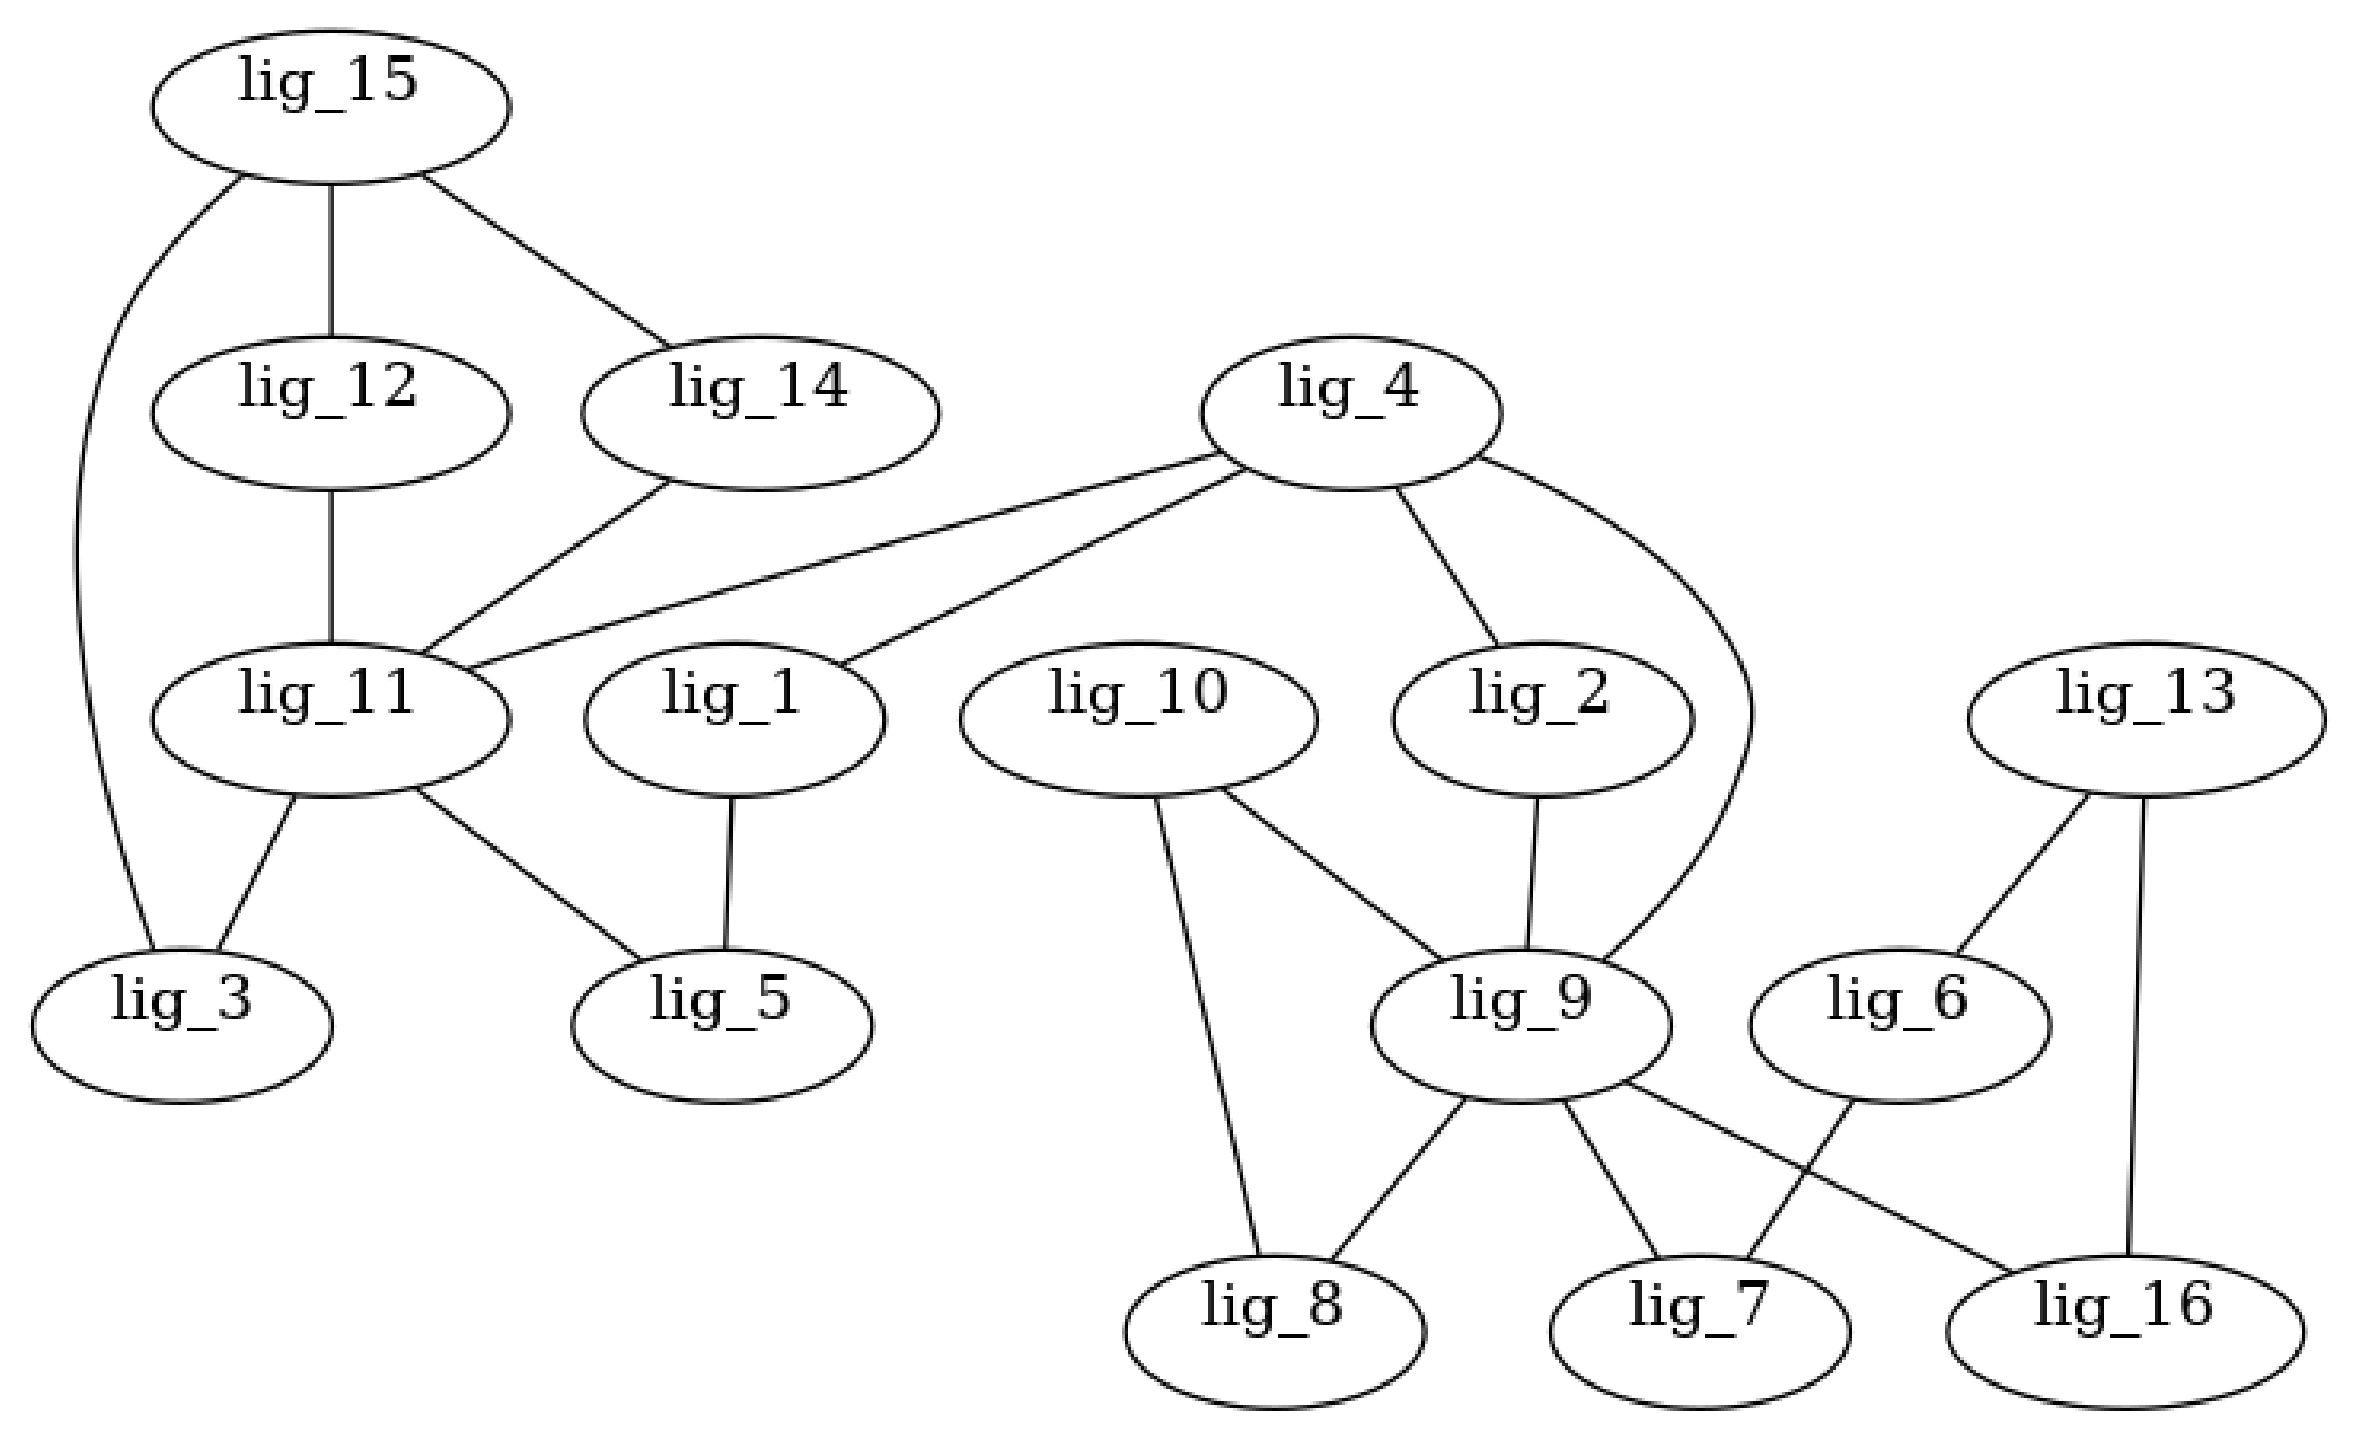

In [305]:
 # Generate the graph.
graph = nx.Graph()

images = glob.glob(f"{lomap_ligand_path}/images/*.png")
# Loop over the nodes and add to the graph.
for i in range(len(nodes)):
    img = images[i]
    graph.add_node(ligand_names[i], image=img, label=ligand_names[i], labelloc="t")


# # Loop over the edges and add to the graph.
for edge in edge_dict.keys():
    graph.add_edge(edge[0], edge[1])
    # print(edge[0], edge[1])
#     graph.add_edge(edge[0],
#                    edge[1],
#                    label=(edge_dict[(edge[0], edge[1])]))
    

# # Convert to a dot graph.
# # nx.draw(graph, with_labels=True)
dot_graph = nx.nx_pydot.to_pydot(graph)

# # # Write to a PNG.
network_plot = f"{lomap_ligand_path}/images/network.png"
dot_graph.write_png(network_plot)
img = mpimg.imread(network_plot)
plt.figure(figsize=(20, 20))
plt.axis("off")
plt.imshow(img)

plt.axis('off')

plt.show()

In [135]:
len(nodes)

16

In [36]:
lomap_database = lomap.DBMolecules(f"{ligand_path}/lomap", output=True)

In [37]:
lomap_database

In [38]:
strict, loose = lomap_database.build_matrices()

In [39]:
strict_numpy = strict.to_numpy_2D_array()
loose_numpy = loose.to_numpy_2D_array()


In [40]:
nx_graph = lomap_database.build_graph()

In [51]:
nodes = nx_graph.nodes(data=True)
ligand_names = []
for node in nodes:
    ligand_name = node[1]["fname_comp"].replace(".sdf", "")
    print(ligand_name)
    ligand_names.append(ligand_name)
    print(node)


lig_1
(0, {'ID': 0, 'fname_comp': 'lig_1.sdf', 'active': False})
lig_10
(1, {'ID': 1, 'fname_comp': 'lig_10.sdf', 'active': False})
lig_11
(2, {'ID': 2, 'fname_comp': 'lig_11.sdf', 'active': False})
lig_12
(3, {'ID': 3, 'fname_comp': 'lig_12.sdf', 'active': False})
lig_13
(4, {'ID': 4, 'fname_comp': 'lig_13.sdf', 'active': False})
lig_14
(5, {'ID': 5, 'fname_comp': 'lig_14.sdf', 'active': False})
lig_15
(6, {'ID': 6, 'fname_comp': 'lig_15.sdf', 'active': False})
lig_16
(7, {'ID': 7, 'fname_comp': 'lig_16.sdf', 'active': False})
lig_2
(8, {'ID': 8, 'fname_comp': 'lig_2.sdf', 'active': False})
lig_3
(9, {'ID': 9, 'fname_comp': 'lig_3.sdf', 'active': False})
lig_4
(10, {'ID': 10, 'fname_comp': 'lig_4.sdf', 'active': False})
lig_5
(11, {'ID': 11, 'fname_comp': 'lig_5.sdf', 'active': False})
lig_6
(12, {'ID': 12, 'fname_comp': 'lig_6.sdf', 'active': False})
lig_7
(13, {'ID': 13, 'fname_comp': 'lig_7.sdf', 'active': False})
lig_8
(14, {'ID': 14, 'fname_comp': 'lig_8.sdf', 'active': False})
l

In [73]:
scores = []
data = []
for i in nx_graph.edges(data=True):
    data.append(i)
    score = i[2]["similarity"]
    first_index = int(i[0])
    second_index = int(i[1])
    scores.append(score)
    # print(f"edge index 1: {first_index}, edge index 2: {second_index}, score: {score}")
    print(f"{ligand_names[first_index]} ====> {ligand_names[second_index]}, score {score}")

lig_1 ====> lig_4, score 0.9048374180359595
lig_1 ====> lig_5, score 0.9048374180359595
lig_10 ====> lig_8, score 0.951229424500714
lig_10 ====> lig_9, score 0.951229424500714
lig_11 ====> lig_3, score 0.7046880897187134
lig_11 ====> lig_14, score 0.8187307530779817
lig_11 ====> lig_4, score 0.8607079764250578
lig_11 ====> lig_5, score 0.8607079764250578
lig_11 ====> lig_12, score 0.9048374180359595
lig_12 ====> lig_15, score 0.8187307530779818
lig_13 ====> lig_16, score 0.9048374180359595
lig_13 ====> lig_6, score 0.951229424500714
lig_14 ====> lig_15, score 0.9048374180359595
lig_15 ====> lig_3, score 0.6376281516217733
lig_16 ====> lig_9, score 0.9048374180359595
lig_2 ====> lig_9, score 0.7788007830714049
lig_2 ====> lig_4, score 0.8607079764250578
lig_4 ====> lig_9, score 0.9048374180359595
lig_6 ====> lig_7, score 0.8607079764250578
lig_7 ====> lig_9, score 0.8607079764250578
lig_8 ====> lig_9, score 0.9048374180359595


0

{(0,
  10): Text(0.01913044571616705, -0.29310697848649425, "{'similarity': 0.9048374180359595, 'strict_flag': True}"),
 (0,
  11): Text(-0.032849633997094785, -0.5726085670963522, "{'similarity': 0.9048374180359595, 'strict_flag': True}"),
 (1,
  14): Text(0.0643502907668762, 0.662842025543398, "{'similarity': 0.951229424500714, 'strict_flag': True}"),
 (1,
  15): Text(0.19924469591592064, 0.5620289279611475, "{'similarity': 0.951229424500714, 'strict_flag': True}"),
 (2,
  9): Text(-0.5570567300893396, -0.6562449130607458, "{'similarity': 0.7046880897187134, 'strict_flag': True}"),
 (2,
  5): Text(-0.5181923067706726, -0.7395040110581445, "{'similarity': 0.8187307530779817, 'strict_flag': True}"),
 (2,
  10): Text(-0.21858563946449514, -0.3425380255275633, "{'similarity': 0.8607079764250578, 'strict_flag': True}"),
 (2,
  11): Text(-0.27056571917775696, -0.6220396141374213, "{'similarity': 0.8607079764250578, 'strict_flag': True}"),
 (2,
  3): Text(-0.614518159471439, -0.579084711314

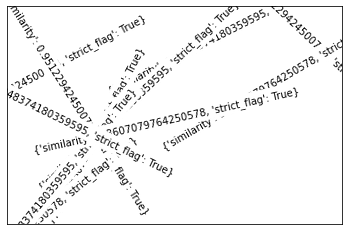

In [67]:
# nx.draw(nx_graph, with_labels=True, font_weight='bold')
nx.draw_networkx_edge_labels(nx_graph, pos=())

In [21]:
MC = lomap.MCS.getMapping(lomap_database[0].getMolecule(), lomap_database[1].getMolecule(), hydrogens=False)


In [22]:
perturbation_network_dict = {}
transformations_named = [(ligand_names[transformation[0]], ligand_names[transformation[1]]) for transformation in transformations]
for transformation, score in zip(transformations_named, lomap_scores):
    # print(transformation, score)
    perturbation_network_dict[transformation] = score

NameError: name 'transformations' is not defined

# VIM-2 Prep


In [29]:
protein_pdb = "../inputs/protein/vim2.amber.pdb"

In [33]:
protein = bss.IO.readMolecules(protein_pdb)[0]
protein_parameters = bss.Parameters.parameterise(protein, "ff14SB").getMolecule()

In [32]:
view = bss.Notebook.View(protein)
# view.system()

In [38]:
bss.Solvent.waterModels()

['spc', 'spce', 'tip3p', 'tip4p', 'tip5p']

In [42]:
zincs_pdb = "../inputs/protein/vim2_zn.pdb"
zincs = bss.IO.readMolecules(zincs_pdb)[0]
zinc_parameters = bss.Parameters.parameterise(zincs, water_model="tip3p", forcefield="ff14SB").getMolecule()

In [31]:
view = bss.Notebook.View(zincs)
# view.system()

In [25]:
hoh_pdb = "../inputs/protein/vim2_hoh.pdb"
hoh = bss.IO.readMolecules(hoh_pdb)[0]


In [43]:
system = protein_parameters + zinc_parameters + hoh

In [44]:
bss.IO.saveMolecules("../inputs/protein/protein", protein, fileformat="pdb")

['/home/jguven/projects/metalloproteins/metallobetalactamases/inputs/protein/protein.pdb']